# Using LSTM to predict NVDA prices

Using LSTM:
- Maintains an internal state, allowing it to have memory of previous inputs

1.	Handling Sequential Data: LSTM (Long Short-Term Memory) networks are specifically designed to handle and predict sequences of data, making them well-suited for time series forecasting like stock prices.
2.	Capturing Long-Term Dependencies: LSTM networks can remember information for long periods, thanks to their ability to maintain a memory cell that updates and forgets information over time. This is crucial for stock price prediction, where historical data can influence future values.

In [1]:
# importing libraries

import pandas as pd # data visualization
import numpy as np # number manipulation
from sklearn.preprocessing import MinMaxScaler # helps to normalize data
from keras.models import Sequential # allows you to build a NN in a sequential stack
from keras.layers import LSTM, Dense # to define the neural network being used + hidden layers

# note that need to pip install tensorflow - keras is built on tensorflow

In [2]:
# load data

data = pd.read_csv('./NVDA.csv')
print(data.head())  # Check the first few rows of the data
data = data[['Date', 'Close']] # keeps only the date and close columns
print(data.head()) # Check the first few rows of the data
data['Date'] = pd.to_datetime(data['Date']) # converts the date column to datetime
data.set_index('Date', inplace=True) # sets the date column as the index

# pre-process data

scaler = MinMaxScaler(feature_range=(0, 1)) # defines the scaler object used to normalise the data
scaled_data = scaler.fit_transform(data) # normalises data using MinMaxScaler -> reminder that range of data fed into a RNN should ideally be 0 to 1

sequence_length = 60 # define input size
X, y = [], [] # X = input data, y = labels
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0]) # X contains groups of 60 data points
    y.append(scaled_data[i, 0]) # y contains the data point right at the end of the 60 points in X 
X, y = np.array(X), np.array(y) # puts X and y into numpy arrays so that they can be reshaped to be fed into the RNN
X = np.reshape(X, (X.shape[0], X.shape[1], 1)) # X.shape -> (number_of_samples, sequence_length) This reshapes X to the format needed for an input for keras

print(X) # X is an array of arrays of 60 closing prices
print(y) # Y is an array of the closing prices of the last day of each of the corresponding arrays in X

split = int(len(X) * 0.8) # 80% train, 20% test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

         Date       Open       High        Low      Close  Adj Close  \
0  2023-06-20  42.998001  43.990002  42.674000  43.807999  43.794888   
1  2023-06-21  43.500999  43.615002  42.080002  43.044998  43.032112   
2  2023-06-22  42.252998  43.425999  42.234001  43.025002  43.012127   
3  2023-06-23  42.464001  42.808998  42.014999  42.209000  42.196365   
4  2023-06-26  42.460999  42.764000  40.099998  40.632000  40.619839   

      Volume  
0  451153000  
1  551603000  
2  417737000  
3  358140000  
4  594322000  
         Date      Close
0  2023-06-20  43.807999
1  2023-06-21  43.044998
2  2023-06-22  43.025002
3  2023-06-23  42.209000
4  2023-06-26  40.632000
[[[0.03655488]
  [0.02854471]
  [0.02833479]
  ...
  [0.0509375 ]
  [0.04770402]
  [0.05416046]]

 [[0.02854471]
  [0.02833479]
  [0.0197682 ]
  ...
  [0.04770402]
  [0.05416046]
  [0.0551683 ]]

 [[0.02833479]
  [0.0197682 ]
  [0.00321246]
  ...
  [0.05416046]
  [0.0551683 ]
  [0.03752075]]

 ...

 [[0.52539527]
  [0.5365548

In [3]:
# Shape: (number_of_samples, sequence_length, no. of features)

# Build LSTM model
model = Sequential()
# input: (batch_size, 60, 1)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # X_train.shape[1] = 60, the second value in the tuple is the number of features which in this case is 1, the closing price
# return_sequence=True: first LSTM layer passes all hidden states to the next LSTM layer eg
# Output = [
#  [
#   [h1_t1, h2_t1, ..., h50_t1],  # 50-dimensional vector at time step 1 for the first sample
#    [h1_t2, h2_t2, ..., h50_t2],  # 50-dimensional vector at time step 2 for the first sample
#    [h1_t3, h2_t3, ..., h50_t3],  # 50-dimensional vector at time step 3 for the first sample
#    [h1_t4, h2_t4, ..., h50_t4]   # 50-dimensional vector at time step 4 for the first sample
#    .. 60 time steps
#  ] .. (depending on the batch size)
# ]

# note that each neuron takes a set of 60 data points, each neuron has a diff weight

# input: (batch_size, 60, 50)
model.add(LSTM(units=50, return_sequences=False)) 
# return_sequence=False: 2nd LSTM layer only returns the FINAL hidden state to the next two layers
# [ h1_t60, 
#  h2_t60, 
#  ... ] 

# output: (batch_size, 50)

# The two LSTM layers help to capture the temporal dependencies in the data

# input: (batch_size, 50)

model.add(Dense(units=25)) # each of the 25 neurons has a weight for each of the 50 neurons in the previous layer
model.add(Dense(units=1)) # the single neuron has a weight for each of the 25 neurons in the previous layer

model.compile(optimizer='adam', loss='mean_squared_error') 
model.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
153/153 [==============================] - 3s 11ms/step - loss: 0.0049
Epoch 2/10
153/153 [==============================] - 2s 12ms/step - loss: 0.0024
Epoch 3/10
153/153 [==============================] - 2s 10ms/step - loss: 0.0020
Epoch 4/10
153/153 [==============================] - 2s 10ms/step - loss: 0.0018
Epoch 5/10
153/153 [==============================] - 2s 10ms/step - loss: 0.0013
Epoch 6/10
153/153 [==============================] - 2s 10ms/step - loss: 0.0011
Epoch 7/10
153/153 [==============================] - 2s 10ms/step - loss: 0.0012
Epoch 8/10
153/153 [==============================] - 2s 10ms/step - loss: 0.0011
Epoch 9/10
153/153 [==============================] - 2s 10ms/step - loss: 9.8816e-04
Epoch 10/10
153/153 [==============================] - 2s 10ms/step - loss: 8.7424e-04


## Choice for optimizer and loss function

adam:
1.	Adaptive Learning Rate: Adjusts the learning rate for each parameter dynamically, combining the benefits of AdaGrad and RMSProp.
2.	Efficiency: Requires little memory and is computationally efficient, making it suitable for large datasets and high-dimensional parameter spaces.

mse:
1. Standard loss function for regression, measuring the average squared difference between actual and predicted values.

In [42]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # inverse normalisation
y_test = scaler.inverse_transform(y_test) # inverse normalisation

2/2 [==============================] - 0s 6ms/step


In [43]:
# Print the shape of the arrays
print("predictions:", predictions)
print("y_test:", y_test)

predictions: [[ 80.81429 ]
 [ 80.14193 ]
 [ 80.25918 ]
 [ 81.72472 ]
 [ 83.58024 ]
 [ 85.0517  ]
 [ 85.44525 ]
 [ 85.799736]
 [ 86.60499 ]
 [ 88.08623 ]
 [ 89.27787 ]
 [ 90.08151 ]
 [ 90.2103  ]
 [ 90.19501 ]
 [ 90.17386 ]
 [ 90.3076  ]
 [ 91.08799 ]
 [ 91.93806 ]
 [ 92.29635 ]
 [ 92.79438 ]
 [ 93.34212 ]
 [ 93.70687 ]
 [ 95.58838 ]
 [ 98.24346 ]
 [102.13135 ]
 [105.92356 ]
 [108.07382 ]
 [108.874374]
 [109.82982 ]
 [110.786026]
 [112.58077 ]
 [113.9913  ]
 [114.88577 ]
 [115.46629 ]
 [115.54414 ]
 [116.11088 ]
 [117.47072 ]
 [119.2225  ]
 [120.56452 ]]
y_test: [[6.59464944e+09]
 [6.83792064e+09]
 [7.25802602e+09]
 [7.25983742e+09]
 [7.14828641e+09]
 [6.87159133e+09]
 [7.10012623e+09]
 [7.34479680e+09]
 [7.62066847e+09]
 [7.49010082e+09]
 [7.47841081e+09]
 [7.34133922e+09]
 [7.43444872e+09]
 [7.47734050e+09]
 [7.55612582e+09]
 [7.82565811e+09]
 [7.80334830e+09]
 [7.64857647e+09]
 [7.83800706e+09]
 [7.88789639e+09]
 [7.85200218e+09]
 [8.58049867e+09]
 [8.80030686e+09]
 [9.41214784e+09]


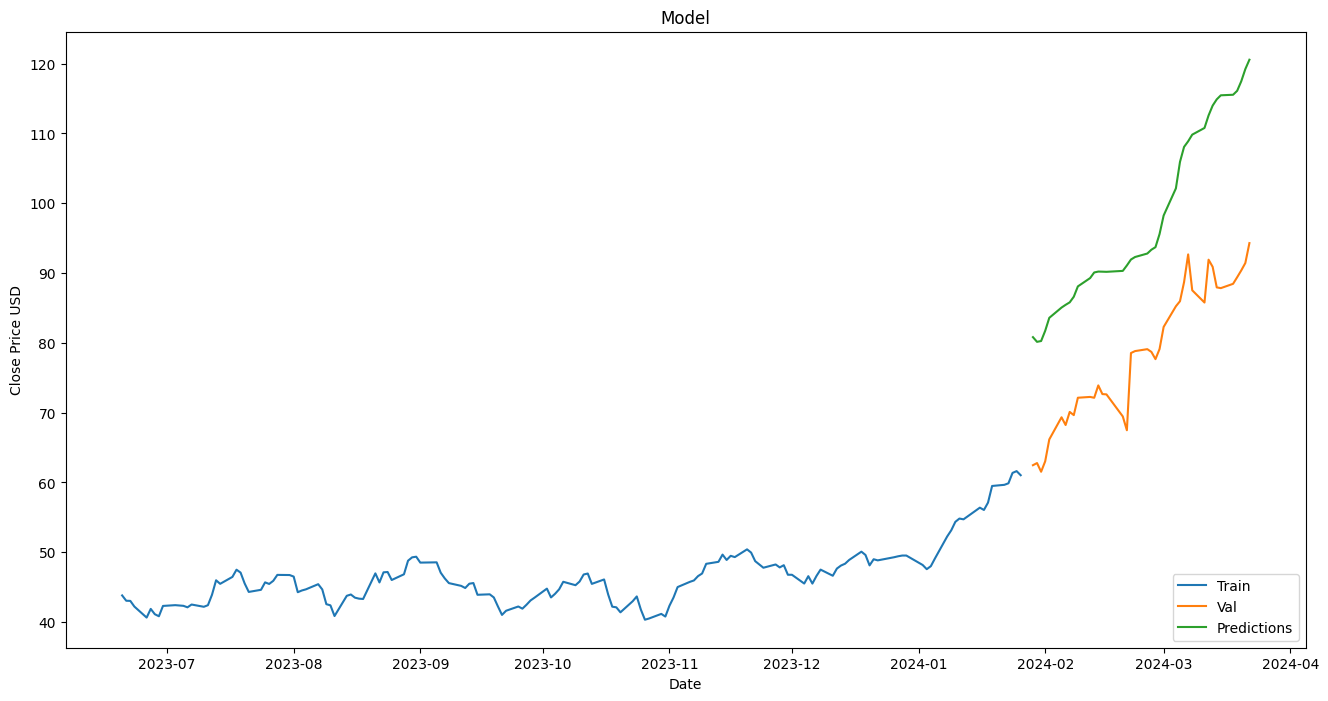

In [44]:
# Visualize predictions
import matplotlib.pyplot as plt

# Assuming data is the original DataFrame with Date and Close columns
train = data[:split]
valid = data[split:]

# Ensure predictions have the same length as valid
valid = valid.iloc[:len(predictions)].copy()
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
plt.show()